# Introdução e Contexto
Neste módulo avançado, vamos lidar com um cenário real e desafiador da indústria farmacêutica: a Triagem Virtual (Virtual Screening).

Utilizaremos o dataset HIV (disponibilizado pelo projeto DeepChem), que contém mais de 40.000 moléculas testadas quanto à sua capacidade de inibir a replicação do vírus HIV.

O Desafio: Este dataset é desbalanceado. A grande maioria das moléculas não funciona (Inativos), e apenas uma pequena fração é eficaz (Ativos). Se usarmos apenas a "Acurácia" como métrica, seremos enganados.

Objetivos de Aprendizado:

Lidar com dados desbalanceados.

Treinar um classificador robusto (Random Forest).

Dominar métricas de avaliação críticas: Matriz de Confusão, Precisão, Recall e Curva ROC.

#1. Configuração e Importação de Dados
Primeiro, importamos as bibliotecas necessárias. Usaremos RDKit para processar a química, Pandas para os dados e Scikit-Learn para a inteligência artificial.

Também configuramos um sistema híbrido de carregamento: o código tenta baixar os dados direto do GitHub; se falhar, procura um arquivo local.

In [ ]:
!pip install rdkit

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    classification_report
)

In [ ]:
url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/HIV.csv'
df = pd.read_csv(url)

df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0


#2. Análise Exploratória (O Perigo do Desbalanceamento)
Antes de treinar, precisamos saber quantos "Ativos" vs "Inativos" existem.

0 (Inativo): A molécula não funcionou.

1 (Ativo): A molécula mostrou atividade contra o HIV.

Observe como a classe 0 é muito maior que a classe 1.


--- Distribuição das Classes ---
Inativos (0): 39684 moléculas
Ativos   (1): 1443 moléculas
Taxa de Ativos: 3.51%


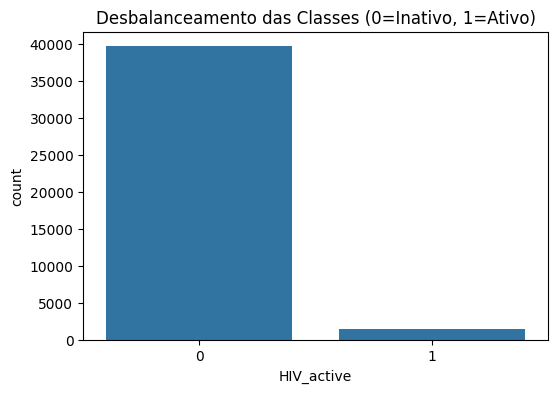

In [ ]:
# Contagem das classes
contagem = df['HIV_active'].value_counts()

print("\n--- Distribuição das Classes ---")
print(f"Inativos (0): {contagem[0]} moléculas")
print(f"Ativos   (1): {contagem[1]} moléculas")

porcentagem_ativos = (contagem[1] / len(df)) * 100
print(f"Taxa de Ativos: {porcentagem_ativos:.2f}%")

# Gráfico de barras para visualizar o desbalanceamento
plt.figure(figsize=(6, 4))
sns.countplot(x='HIV_active', data=df)
plt.title("Desbalanceamento das Classes (0=Inativo, 1=Ativo)")
plt.show()

#3. Engenharia de Features (Fingerprints)
O modelo não lê a string SMILES ("CCO..."). Precisamos converter isso para números. Usaremos Morgan Fingerprints (ECFP4) com 2048 bits.

Nota: Este processo pode demorar 1 ou 2 minutos, pois estamos processando 40 mil moléculas.

###  4. Predição e Comparativo

Agora pedimos ao modelo: *"Preveja o LogP dessas moléculas!"*.
Em seguida, comparamos com o gabarito.

Vamos exibir uma tabela lado a lado. Observe onde o erro foi pequeno (o modelo "entendeu" a molécula) e onde foi grande (o modelo se confundiu).

In [ ]:
def gerar_fp_numpy(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return None

        # --- CÓDIGO ATUALIZADO (Novo Gerador) ---
        # Substitui o antigo GetMorganFingerprintAsBitVect
        gen = AllChem.GetMorganGenerator(radius=2, fpSize=2048)
        fp = gen.GetFingerprint(mol)
        # ----------------------------------------

        arr = np.zeros((0,), dtype=np.int8)
        DataStructs.ConvertToNumpyArray(fp, arr)
        return arr
    except:
        return None

df['fingerprint'] = df['smiles'].apply(gerar_fp_numpy)

df_clean = df.dropna(subset=['fingerprint'])
df_clean.head()

X = np.stack(df_clean['fingerprint'].values)
y = df_clean['HIV_active'].values

print(X.shape, y.shape)


[01:15:01] Explicit valence for atom # 3 Al, 6, is greater than permitted
[01:15:01] Explicit valence for atom # 5 B, 5, is greater than permitted
[01:15:06] Explicit valence for atom # 16 Al, 9, is greater than permitted
[01:15:08] Explicit valence for atom # 4 Al, 9, is greater than permitted
[01:15:13] Explicit valence for atom # 12 Al, 7, is greater than permitted
[01:15:13] Explicit valence for atom # 13 Al, 7, is greater than permitted
[01:15:15] WARNING: not removing hydrogen atom without neighbors
[01:15:15] WARNING: not removing hydrogen atom without neighbors
[01:15:15] Explicit valence for atom # 6 Ge, 5, is greater than permitted


(41120, 2048) (41120,)


#5. Divisão e Treinamento (Random Forest)
Agora vamos dividir os dados em Treino e Teste.

Estratégia Importante: Usamos stratify=y. Isso obriga o Scikit-Learn a manter a mesma proporção de ativos (3.5%) tanto no treino quanto no teste.

O Modelo: Usamos RandomForestClassifier.

O "Pulo do Gato": class_weight='balanced'. Isso diz ao modelo: "Preste muito mais atenção nos erros da classe minoritária (Ativos)".

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
random_forest.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

#6. Avaliação Profunda (Métricas)
Aqui está o coração deste módulo. Vamos analisar o desempenho além da acurácia.

Matriz de Confusão: Onde exatamente o modelo errou?

Relatório de Classificação: Precision, Recall e F1-Score.

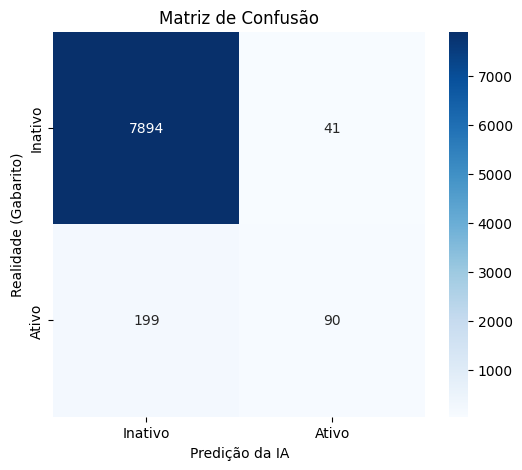


Relatório de Métricas:
              precision    recall  f1-score   support

     Inativo       0.98      0.99      0.99      7935
       Ativo       0.69      0.31      0.43       289

    accuracy                           0.97      8224
   macro avg       0.83      0.65      0.71      8224
weighted avg       0.97      0.97      0.97      8224



In [ ]:
y_pred = random_forest.predict(X_test)

y_prob = random_forest.predict_proba(X_test)[:, 1]

matriz_confusao = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Inativo', 'Ativo'],
            yticklabels=['Inativo', 'Ativo'])
plt.title('Matriz de Confusão')
plt.ylabel('Realidade (Gabarito)')
plt.xlabel('Predição da IA')
plt.show()

print("\nRelatório de Métricas:")
print(classification_report(y_test, y_pred, target_names=['Inativo', 'Ativo']))

#7. Curva ROC e AUC
A Curva ROC nos ajuda a visualizar a capacidade do modelo de ordenar as moléculas.

AUC > 0.8: Excelente.

AUC = 0.5: Aleatório (Moeda).

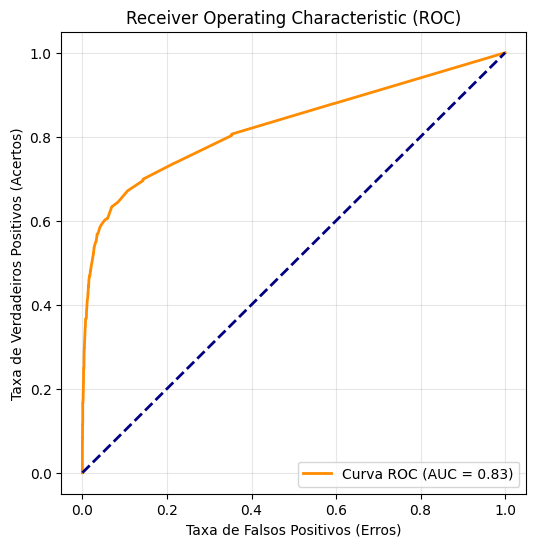

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #
plt.xlabel('Taxa de Falsos Positivos (Erros)')
plt.ylabel('Taxa de Verdadeiros Positivos (Acertos)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#8. Interpretação dos Resultados

A acurácia de 0.97 quer dizer que o modelo acerta 97% de todas as previsões, porém como 96% do dataset são moléculas inativas, se o modelo chutasse que tudo é inativo ia ter uma acurácia muito boma também.

Este valor de 0.97 é inflado pela classe marjoritária do dataset, logo não é uma métrica muito boa neste contexto.

O Reccal dos Ativos, de todas as moléculas ativas do dataset o modelo so encontrou 31% delas, isto que dizer que ele deixou passar 69% dos potenciais remédios.

Precisão dos Ativos, quando o modelo acha um ativo ele está certo 69% das vezes, um resultado bom.

Um AUC de 0.83 é excelente, ainda mais considerando o dataset desbalanceado.
Este valor significa de se ele pegar uma molécula ativa e uma Inativa existe 83% de chance do modelo da uma pontuação maior para a molécula ativa, ou seja ele conseguiria oredernar bem as moleculas, quais devem ficar no topo da lista e quais no fundo.